# NIH Chest X-Ray Dataset: Dimensionality Reduction

## Load Libraries

In [6]:
from torchxrayvision.datasets import XRayCenterCrop, XRayResizer
from drift_detection.drift_detector import Reductor
from torchxrayvision.datasets import NIH_Dataset
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import numpy as np
import torch

## Load Dataset

In [8]:
# paths for NIH dataset
IMAGE_PATH = '~/NIHCXR/images'
CSV_PATH = '~/NIHCXR/Data_Entry_2017.csv'

# load NIH dataset
dataset = NIH_Dataset(IMAGE_PATH, CSV_PATH, 
                      views=['AP', 'PA'], unique_patients=False, 
                      transform=transforms.Compose([XRayCenterCrop(),
                                                    XRayResizer(224, engine='cv2')]))

# grab random subset of 400 image indices from dataset
indices = np.random.randint(len(dataset), size=400) 
dataset = Subset(dataset, indices)

Setting XRayResizer engine to cv2 could increase performance.


## Sample Images

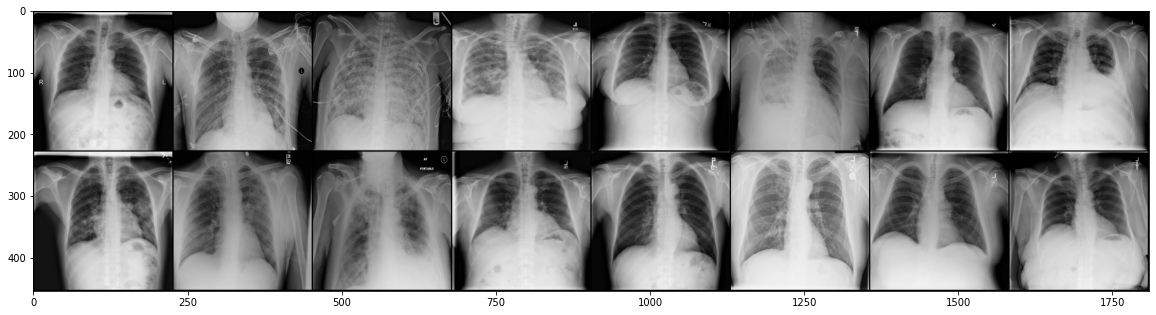

In [54]:
imgs = torch.concat([torch.tensor(img['img']) for img in dataset]).unsqueeze(1)

plt.figure(figsize=(20,10))
plt.imshow(make_grid(a[np.random.randint(400, size=16)], normalize=True).permute(1,2,0), cmap='gray')

## TorchXRayVision Trained Autoencoder

    Reduce Dimensionality of images by using the representations extracted from the bottleneck of the 
    TorchXRayVision trained autoencoder.

```X_input``` shape: (400, 1, 224, 224)

In [15]:
from drift_detection.drift_detector import Reductor
reductor = Reductor("TAE_txrv_CNN")
X_transformed, y = reductor.transform(dataset, num_workers=4)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  6.79it/s]


In [16]:
print("X_transformed shape: ", X_transformed.shape, "\tlabels shape: ", y.shape)

X_transformed shape:  (400, 512) 	labels shape:  (400, 14)


## TorchXRayVision Classifier (BBSDs)
    Reduce dimensionality of images with the TorchXRayVision Classifier; returns the softmax probability 
    distribution of multi-class prediction of 18 pathologies.

In [12]:
reductor = Reductor("BBSDs_txrv_CNN")
X_transformed, y = reductor.transform(dataset, num_workers=4)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.27it/s]


In [13]:
print("X_transformed shape: ", X_transformed.shape, "\tlabels shape: ", y.shape)

X_transformed shape:  (400, 18) 	labels shape:  (400, 14)


The intersection of the model predictions and the NIH dataset labels yield 10 overlapping pathologies:

In [14]:
np.intersect1d(reductor.model.pathologies, dataset.dataset.pathologies)

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype='<U26')